**Add Necessary Libraries** 

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

**Adding a dataset and getting to know it**

In [50]:
df = pd.read_csv('dynamic_pricing.csv')

In [51]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


**Let's visualize some plots**

1. relationship between expected ride duration and the historical cost of the ride

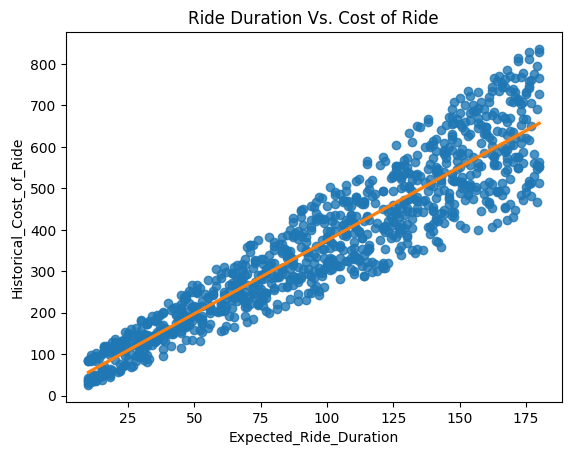

In [53]:
sns.regplot(
    data=df,
    x='Expected_Ride_Duration',
    y='Historical_Cost_of_Ride',
    line_kws=dict(color='C1'),
)
plt.title('Ride Duration Vs. Cost of Ride');

2. distribution of the historical cost of rides based on the vehicle type

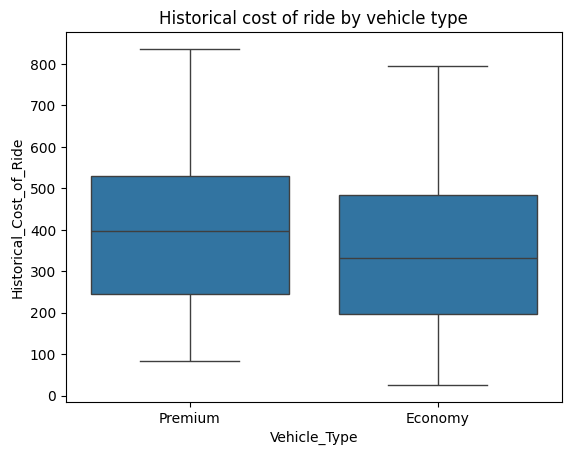

In [54]:
sns.boxplot(
    data=df,
    x='Vehicle_Type',
    y='Historical_Cost_of_Ride'
)
plt.title('Historical cost of ride by vehicle type');

3. Now let’s have a look at the correlation matrix

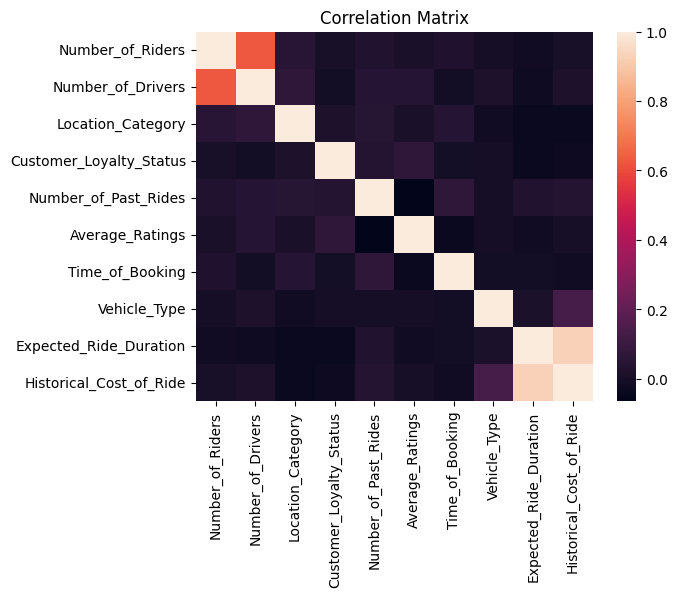

In [55]:
df_encoded = df.copy()

for col in df.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df[col])

df_corr = df_encoded.corr()

sns.heatmap(data=df_corr)
plt.title('Correlation Matrix');

The data provided by the company states that the company uses a pricing model that only takes the expected ride duration as a factor to determine the price for a ride.

Now, we will implement a dynamic pricing strategy aiming to adjust the ride costs dynamically based on the demand and supply levels observed in the data

In [56]:
'''
If the number of passengers is greater than the 75% percentile:
we divide it by the 75th percentile.
If it is less, we divide it by the 25th percentile.
'''

high_demand_percentile = np.percentile(df['Number_of_Riders'], 75)
low_demand_percentile = np.percentile(df['Number_of_Riders'], 25)

df['demand_multiplier'] = np.where(
    df['Number_of_Riders'] > high_demand_percentile,
    df['Number_of_Riders'] / high_demand_percentile,
    df['Number_of_Riders'] / low_demand_percentile)

'''
If the number of drivers is greater than the 25th percentile:
We calculate the multiplication as (75th percentile divided by the number of drivers). 
Otherwise, we use the value (25th percentile divided by the number of drivers).
'''

high_supply_percentile = np.percentile(df['Number_of_Drivers'], 75)
low_supply_percentile = np.percentile(df['Number_of_Drivers'], 25)

df['supply_multiplier'] = np.where(
    df['Number_of_Drivers'] > low_supply_percentile,
    high_supply_percentile / df['Number_of_Drivers'],
    low_supply_percentile / df['Number_of_Drivers'])

'''
If demand is high and supply is low, the cost of travel increases,
If demand is low and supply is high, the cost of travel decreases.
'''

df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], 0.8) *
    np.maximum(df['supply_multiplier'], 0.8)
)

* In the above code, we first calculated the demand multiplier by comparing the number of riders to percentiles representing high and low demand levels. If the number of riders exceeds the percentile for high demand, the demand multiplier is set as the number of riders divided by the high-demand percentile. Otherwise, if the number of riders falls below the percentile for low demand, the demand multiplier is set as the number of riders divided by the low-demand percentile.

* Next, we calculated the supply multiplier by comparing the number of drivers to percentiles representing high and low supply levels. If the number of drivers exceeds the low-supply percentile, the supply multiplier is set as the high-supply percentile divided by the number of drivers. On the other hand, if the number of drivers is below the low-supply percentile, the supply multiplier is set as the low-supply percentile divided by the number of drivers.

* Finally, we calculated the adjusted ride cost for dynamic pricing. It multiplies the historical cost of the ride by the maximum of the demand multiplier and a lower threshold (demand_threshold_low), and also by the maximum of the supply multiplier and an upper threshold (supply_threshold_high). This multiplication ensures that the adjusted ride cost captures the combined effect of demand and supply multipliers, with the thresholds serving as caps or floors to control the price adjustments.

Now let’s calculate the profit percentage we got after implementing this dynamic pricing strategy

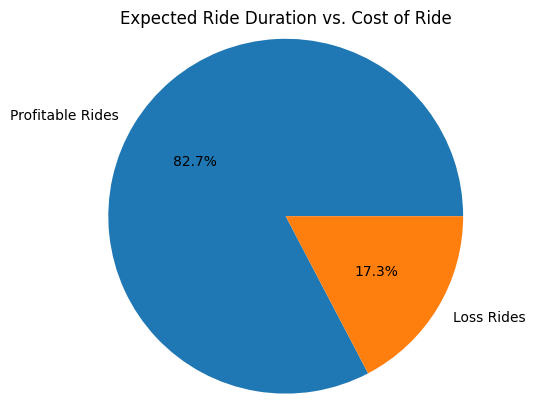

In [57]:
# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) / df['Historical_Cost_of_Ride']) * 100

# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]

profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a pie chart to show the distribution of profitable and loss rides
values = [profitable_count, loss_count]
labels = ['Profitable Rides', 'Loss Rides']

fig, ax = plt.subplots()
ax.pie(
    x=values,
    labels=labels,
    autopct='%1.1f%%',
    radius=1.2,
    
    
)
plt.title('Expected Ride Duration vs. Cost of Ride');

Now let’s have a look at the relationship between the expected ride duration and the cost of the ride based on the dynamic pricing strategy

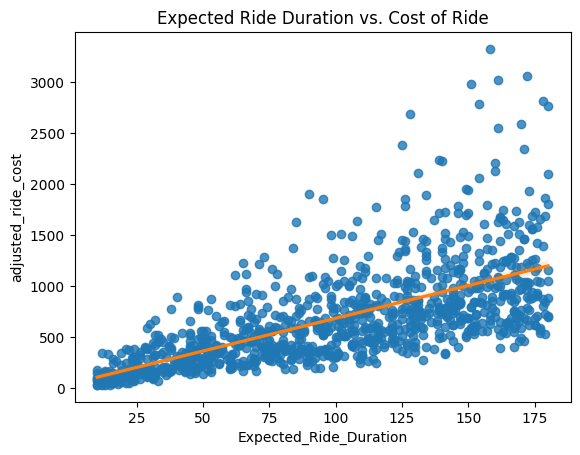

In [58]:
sns.regplot(
    data=df,
    x='Expected_Ride_Duration',
    y='adjusted_ride_cost',
    line_kws=dict(color='C1')
)
plt.title('Expected Ride Duration vs. Cost of Ride');

**Data Preprocessing Pipeline**

In [59]:
def data_preprocessing_pipline(df):

    numeric_features = df.select_dtypes(include=['float', 'int']).columns
    categorical_features = df.select_dtypes(include='object').columns

    '''
    In this dataset we do not have missing values,
    but if we had them in another dataset,
    we can handle missing values ​​with this command.
    '''
    # df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

    # detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        df[feature] = np.where(
            (df[feature] < lower_bound) | (df[feature] > upper_bound),
            df[feature].mean(),
            df[feature]
        )

    #Handle missing values in categorical features
    df[categorical_features] = df[categorical_features].fillna(df[categorical_features].mode().iloc[0])

    return df

As vehicle type is a valuable factor, let’s convert it into a numerical feature.

In [60]:
df['Vehicle_Type'] = df['Vehicle_Type'].map({
    "Premium": 1,
    'Economy': 0
})

Now let’s split the data and train a Machine Learning model to predict the cost of a ride

In [72]:
x = np.array(df[['Number_of_Riders', 'Number_of_Drivers', 'Vehicle_Type', 'Expected_Ride_Duration']])
y = np.array(df[['adjusted_ride_cost']])

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

**Training a model**

In [73]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

**Testing model**

In [70]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        'Premium': 1,
        'Economy': 0
    }

    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric

def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    
    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

# Example prediction using user input values
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = "Economy"
Expected_Ride_Duration = 30
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print('predicted price:', predicted_price)

predicted price: [289.19674279]


Here’s a comparison of the actual and predicted results

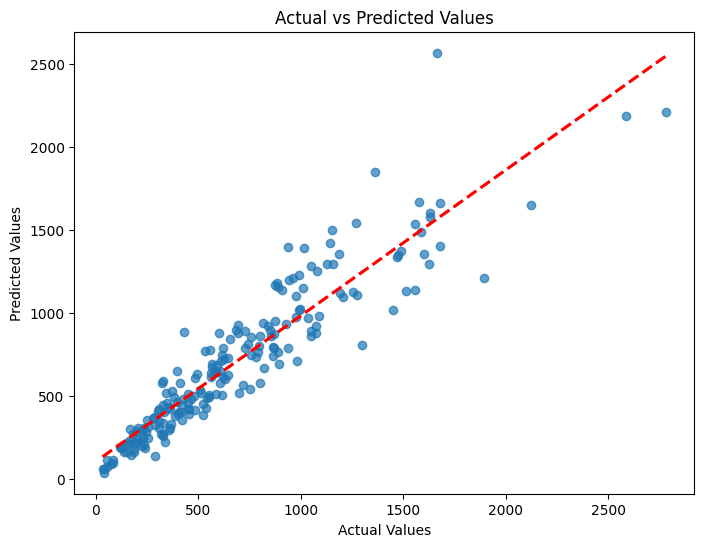

In [ ]:
y_pred = model.predict(X_test)

y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

plt.figure(figsize=(8, 6))
sns.regplot(
    x=y_test_flat,
    y=y_pred_flat,
    scatter_kws={'alpha': 0.7},
    line_kws={'color': 'red', 'linestyle': 'dashed'},
    ci=None
)

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values');